# Import necessary modules and packages

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy.io

# Compute Content Cost : J(C,G)
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

## Unrolling activation
<img src="./images/NST_LOSS.png">

In [3]:
def content_cost(a_C, a_G):
    """
        computer the content cost 
        
        Returns:
            J_content = computed content cost using formula 
    """
    
    ## unroll the activations of both content image and generated image
    # ---- doing unroll means reshaping (1, nH, nW, nC) into (nC, nH x nW)
    # ---- doing unroll makes intuition for mathematics simple
    
    ## to unroll, first I'll get nH, nW and nC separately
    # ---- the shape of a_C is (1, nH, nW, nC). So we can get shape from a_C
    m, nH, nW, nC = a_G.get_shape().as_list()
    
    ## -- now unrolling the activations
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[-1, nC]), perm=[1,0])
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[-1, nC]), perm=[1,0])
    
    ## Using the above formula to calculate Content Cost
    J_content = 1/(4*nH*nW*nC)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    return J_content

In [4]:
## Testing the content cost function
a_C_test = tf.random_normal(shape=[1, 2, 2, 3], seed=1)
a_G_test = tf.random_normal(shape=[1, 2, 2, 3], seed=2)
J_test = content_cost(a_C_test, a_G_test)
with tf.Session() as s:
    print(J_test.eval())

0.22907178


# Compute Style Cost

Computing style cost is little different.
Content cost gives mathematical result showing how similar these two images looks.
More similar means more towards zero

But computing style gives mathematical result showing how similar are the features or styles rather than the content.

That is why the total cost gives error by using both costs.
Content cost computes for determining how much the images are same no matter color, style
Style cost computes for determining how much the style of images are similar to each other rather than content
Eg. Font style of a and b --> style cost 
    letter a and b --> content cost

## Gram Matrix
so for computing style cost we should not compare the activations directly.
rather we will get a new tensor which contains style of activation and we can do similar computation of cost as that of content cost.
So that new tensor is nothing but the gram matrix  
$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

<img src="./images/gram.png">

In [5]:
def gram_matrix(A):
    """
        This will return the gram/style matrix of the given activation.
    """
    
    ## Creating a gram matrix using the formula given above
    gram_matrix = tf.matmul(A, tf.transpose(A))
    
    return gram_matrix

In [6]:
## testing the gram matrix
A_test = tf.random_normal([3, 4], seed=1)
with tf.Session() as s:
    print(s.run(gram_matrix(A_test)))

[[8.833343   6.0216265  1.1906686 ]
 [6.0216265  5.217665   0.83763474]
 [1.1906686  0.83763474 1.0097638 ]]


## Style Cost
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$
* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.

In [7]:
def style_cost(a_S, a_G):
    """
    Computes the style cost between given activations
    """
    
    ## Get shape for computing the formula and unrolling
    m, nH, nW, nC = a_G.get_shape().as_list()
    
    ## Unrolling the activation
    a_S_unrolled = tf.transpose(tf.reshape(a_S, shape=[-1, nC]), perm=[1,0])
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[-1, nC]), perm=[1,0])
    
    ## Gram matrix of the activations
    G_S = gram_matrix(a_S_unrolled)
    G_G = gram_matrix(a_G_unrolled)
    
    ## Compute the style cost using the formula
    J_style = 1/((2*nC*nH*nW)**2)*tf.reduce_sum(tf.square(tf.subtract(G_S, G_G)))
    
    return J_style
    

In [8]:
## Testing the content cost function
a_S_test = tf.random_normal(shape=[1, 2, 2, 3], seed=1)
a_G_test = tf.random_normal(shape=[1, 2, 2, 3], seed=2)
J_test = content_cost(a_C_test, a_G_test)
with tf.Session() as s:
    print(J_test.eval())

0.22907178


## Loading the model
The model is in .mat format. We need to create VGG-model architechture and load weights from .mat file into the model created. 

In [9]:
def load_vgg(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    ## some constants
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    
    ## Load .mat file
    vgg = scipy.io.loadmat(path)
    
    ############### -------- helpful functions --------- ##############
    
    ## first we need to load the weights on a certain layer
    # ---- to do this, we need to create a load_weight function
    def _load_weigths(layer, layer_name):
        """
        Returns weight for given layer
        """
        # ---- Loading weights and biases dictionary
        w_b = vgg['layers'][0][layer][0][0][2]
        w = w_b[0][0]
        b = w_b[0][1]
        
        # ---- checking layer_name for ensuring
        layer_name_c = vgg["layers"][0][layer][0][0][0][0]
        assert layer_name_c == layer_name
        
        return w, b
    
    ## conv_relu function at once
    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Returns conv ---> relu directly
        """
        # ---- Retrieving weight and bias
        W, b = _load_weigths(layer, layer_name)
        
        # ---- we need to convert W and b in tensor form
        W = tf.constant(W)
        
        # ---- flatten b so that the dimension is not broadcasted to b 
        # ---- b should be broadcasted to conv instead conv to b
        b = tf.constant(np.ndarray.flatten(b))
        
        # ---- conv layer
        conv = tf.nn.conv2d(prev_layer, filter=W, strides=[1,1,1,1], padding="SAME") + b
        
        # ---- relu layer
        relu = tf.nn.relu(conv)
        
        return relu
    
    ## average pool function 
    # ---- vgg-19 uses max pool but recommends average pool
    def _avgpool(prev_layer):
        """
        Returns averagePooling layer
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    ############### --------- end of helpful function --------- ###################
    
    
    
    ## we will create a network as in the given configuration
    # ---- create empty dictionary for network storage
    net = {}
    
    # ---- We need activation layer from each convolutions 
    # ---- so it is not worth to store every layer in net dictionary
    # ---- so we store conv2d --> relu as layer "conv_<index>"
    # ---- instead of doing this step at repeating time, we had make a custom function for that
    # ---- graph input is variable because it is the variable manipululated to reduce loss
    # ---- only generated image input is setted for optimization
    net['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    net['conv1_1']  = _conv2d_relu(net['input'], 0, 'conv1_1')
    net['conv1_2']  = _conv2d_relu(net['conv1_1'], 2, 'conv1_2')
    net['avgpool1'] = _avgpool(net['conv1_2'])
    net['conv2_1']  = _conv2d_relu(net['avgpool1'], 5, 'conv2_1')
    net['conv2_2']  = _conv2d_relu(net['conv2_1'], 7, 'conv2_2')
    net['avgpool2'] = _avgpool(net['conv2_2'])
    net['conv3_1']  = _conv2d_relu(net['avgpool2'], 10, 'conv3_1')
    net['conv3_2']  = _conv2d_relu(net['conv3_1'], 12, 'conv3_2')
    net['conv3_3']  = _conv2d_relu(net['conv3_2'], 14, 'conv3_3')
    net['conv3_4']  = _conv2d_relu(net['conv3_3'], 16, 'conv3_4')
    net['avgpool3'] = _avgpool(net['conv3_4'])
    net['conv4_1']  = _conv2d_relu(net['avgpool3'], 19, 'conv4_1')
    net['conv4_2']  = _conv2d_relu(net['conv4_1'], 21, 'conv4_2')
    net['conv4_3']  = _conv2d_relu(net['conv4_2'], 23, 'conv4_3')
    net['conv4_4']  = _conv2d_relu(net['conv4_3'], 25, 'conv4_4')
    net['avgpool4'] = _avgpool(net['conv4_4'])
    net['conv5_1']  = _conv2d_relu(net['avgpool4'], 28, 'conv5_1')
    net['conv5_2']  = _conv2d_relu(net['conv5_1'], 30, 'conv5_2')
    net['conv5_3']  = _conv2d_relu(net['conv5_2'], 32, 'conv5_3')
    net['conv5_4']  = _conv2d_relu(net['conv5_3'], 34, 'conv5_4')
    net['avgpool5'] = _avgpool(net['conv5_4'])
    
    # ---- we will not use fully connected layers. You know why ;)
    
    return net

## Interactive session

In [10]:
## We need to create a session before creating a network
# ---- reset previous graph
tf.reset_default_graph()

# ---- create a new session
sess = tf.InteractiveSession()

In [11]:
net = load_vgg("pretrained_model/imagenet-vgg-verydeep-19.mat")

In [12]:
net

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>,
 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>,
 'conv4_2': <tf.Tensor 'R

# Styles to use from different layers
### Style Weights

* So far you have captured the style from only one layer. 
* We'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$.
* By default, we'll give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$


In [13]:
## We will use following layers for style extractions from activations 
# ---- second index of tuple is coeff. i.e. dependence to layer's style
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

def style_cost_multiple_layers(model, STYLE_LAYERS):
    """
    Computes cost using several layers for style dependency
    """
    ## Initialize style cost
    J_style = 0
    
    # ---- we will use the above given formula in markdown
    for layer_name, coeff in STYLE_LAYERS:
        # ---- getting the activation_layer tensor
        activation_layer = model[layer_name]
        
        # ---- since we will assign the style image as input, when we run the activation layer tensor, we will
        # ---- get computed activation layer for style image
        a_S = sess.run(activation_layer)
        
        # ---- input of generated image will be assigned at the time of training. 
        # ---- so we will leave it as unassigned tensor 
        # ---- Note that input variable for this activation need to be changed to optimize the cost.
        # ---- just like w and b, we will initialize(assign) the input and then optimizer will compute new value
        # ---- of it.
        a_G = activation_layer
        
        # ---- style cost of single layer
        J_style_layer = style_cost(a_S, a_G)
        
        # ---- computing style cost for multiple layers
        J_style += J_style_layer * coeff
    
    return J_style

# Total Cost 
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [14]:
def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    Compute total cost
    """
    
    J_total = alpha*J_content + beta*J_style
    
    return J_total

## Loading the images

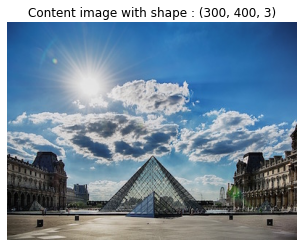

In [15]:
# ---- loading content image
content_image = cv2.imread("data/louvre_small.jpg")
saved_dimen = content_image.shape
content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)
content_image = cv2.resize(content_image, (400, 300))

# ---- ploting image
plt.title("Content image with shape : "+str(content_image.shape))
plt.axis('off')
plt.imshow(content_image)

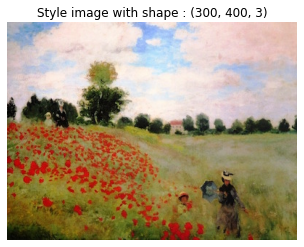

In [16]:
# ---- loading style image
style_image = cv2.imread("data/monet.jpg")
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
style_image = cv2.resize(style_image, (400, 300))

# ---- ploting image
plt.axis('off')
plt.title("Style image with shape : "+str(style_image.shape))
plt.imshow(style_image)

**Since the expected image used as input in VGG is subtracted by mean and shape (1, h, w, c), we will reshape and reduce it by mean**

In [17]:
## reshaping of images : (h, w, c) -> (1, h, w, c)
content_image = np.reshape(content_image, ((1,)+content_image.shape))
style_image = np.reshape(style_image, ((1,)+style_image.shape))

## reducing by mean
# ---- mean is to be subtracted for each channel
mean = np.array([123.68, 116.779, 103.939])

# ---- for enabling broadcasting of subtraction, we need to reshape mean
mean = mean.reshape((1,1,1,3))

## reducing image by mean
content_image = content_image - mean
style_image = style_image - mean


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


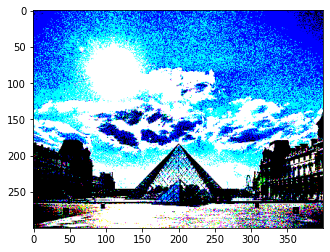

In [18]:
## Now we need to make a generated image with random noise [initialization of generated image]
# ---- first make a noisy image
# Generate a random noise_image
noise_image = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype('float32')

# Set the input_image to be a weighted average of the content_image and a noise_image
noise_ratio = 0.6
generated_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

plt.imshow(generated_image[0])

## Calculation of costs

### Content cost

In [19]:
# Assign the content image to be the input of the VGG model.  
sess.run(net['input'].assign(content_image))

# Select the tensor of layer conv4_2 i.e activation layer
activation = net['conv4_2']

# Now it is value rather than a tensor which do computation for input as content image
a_C = sess.run(activation)

print("type(a_C): ", type(a_C))

# type of activation is still a tensor (unassigned and uncomputed tensor)
print("type(activation): ", type(activation))

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = activation

# Compute the content cost
J_content = content_cost(a_C, a_G)

type(a_C):  <class 'numpy.ndarray'>
type(activation):  <class 'tensorflow.python.framework.ops.Tensor'>


### Style Cost

In [20]:
# Assign the input of the model to be the "style" image 
sess.run(net['input'].assign(style_image))

# Compute the style cost
J_style = style_cost_multiple_layers(net, STYLE_LAYERS)

# Optimizer
<img src="./images/computation_graph.svg">

In [21]:
## Calculation of total cost to optimize
J = total_cost(J_content, J_style)

We will use adam optimizer to optimize the loss

In [22]:
# define optimizer with learning rate
optimizer = tf.train.AdamOptimizer(2.0)

# define what need to be optimized
train_me = optimizer.minimize(J)

## Now we will make a model to train

In [23]:
from IPython.display import clear_output

# ---- Initalize global variables
sess.run(tf.global_variables_initializer())

# ---- assign input of network to generated image
sess.run(net["input"].assign(generated_image))

print("Started training")

# ---- now iterate until successfully trained
for i in range(200):
    sess.run(train_me)
    
    # ---- retrieve generated image after each training step
    generated_image = sess.run(net["input"])
    
    # print cost
    Js, Jc, Jt = sess.run([J_style, J_content, J])
    clear_output(wait=True)
    print(i/2, "%")
    print("iterations : ", i)
    print("Total cost : ", Jt)
    print("style cost : ", Js)
    print("content cost : ", Jc)

    # Normalize image
    img = generated_image + mean

    # clip the image with values from 0 to 255 
    img = np.clip(img, 0, 255).astype('uint8')

    if i%20 == 0:
        # ---- save the generated image after every 20 iterations
        cv2.imwrite('saved_images/'+str(i)+'.png', img[0])

# Normalize image
img = generated_image + mean

# clip the image with values from 0 to 255 
img = np.clip(img, 0, 255).astype('uint8')

cv2.imwrite('saved_images/final.png', img[0])

99.5 %
iterations :  199
Total cost :  88179110.0
style cost :  2199804.5
content cost :  18693.8


True

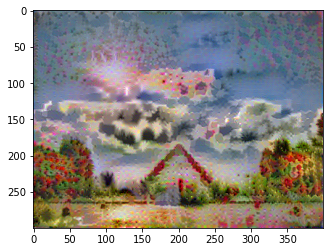

In [31]:
a = cv2.imread("saved_images/final.png")
b = generated_image + mean 
b = np.clip(b, 0, 255).astype('uint8')
plt.imshow(b[0])